In [2]:
%%time
# Author: Michael Djaballah
# Last edited: 
# Last edited by: Michael Djaballah

import yfinance as yf
import pandas as pd
from datetime import datetime
import os
from time import sleep
from dateutil.relativedelta import relativedelta
import sklearn as sk
from sklearn.preprocessing import StandardScaler
import seaborn as sns

CPU times: user 760 ms, sys: 224 ms, total: 984 ms
Wall time: 1.37 s


In [6]:
# Functions to maintain and call the S&P 500 from a current date
# Author Michael Djaballah
# Time last edited: 11:03 PM June 14, 2020
# Last edited by: Michael Djaballah

# Takes no input
# Output is newly saved CSV's containing the current makeup of the S&P 500 
# and its historical additions and removals
# data_path is changeable depending on desired save location
def get_snp_store(data_path='data/'):
    curr_raw = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    
    curr = curr_raw[0]
    hist = curr_raw[1]
    
    new_hist = pd.DataFrame(hist['Date'])
    new_hist['Added'] = hist['Added', 'Ticker']
    new_hist['Removed'] = hist['Removed', 'Ticker']
    
    os.makedirs(data_path, exist_ok=True)
    
    curr.to_csv(data_path + 'snp_current.csv', index=False)
    new_hist.to_csv(data_path + 'snp_hist.csv', index=False)
    return None


# Input: a date in string form with its corresponding format:
# Ex: 'January 1, 2020', '%B %d, %Y'
# Output: a list containing the S&P 500 at the input date
def build_snp(date, date_format='%Y-%m-%d', data_path='data/'):
    get_snp_store(data_path=data_path)
    curr = pd.read_csv(data_path + 'snp_current.csv')
    hist = pd.read_csv(data_path + 'snp_hist.csv')
    
    start_date = datetime.strptime(date, date_format)
    
    snp_set = set(curr['Symbol'])
    date_format2 = '%B %d, %Y'
    
    for i in range(len(hist)):
        temp_date = datetime.strptime(hist.iloc[i]['Date'], date_format2)
        if temp_date < start_date:
            break

        tb_removed = hist.iloc[i]['Added']
        tb_added = hist.iloc[i]['Removed']

        if tb_removed in snp_set:
            snp_set.remove(tb_removed)
        if not type(tb_added) == float:
            snp_set.add(tb_added)
    
    return list(snp_set)


def build_returns(portfolio, tickers, date):
    returns = []
    for ticker in tickers:
        temp_ticker_dict = portfolio[ticker].set_index('Date').loc[date]
        returns.append((temp_ticker_dict['Close'] - temp_ticker_dict['Open'])/temp_ticker_dict['Open'])
    return returns

In [7]:
from portfolio import Portfolio

In [13]:
universe = build_snp('2015-01-01')

In [14]:
start_date = '2015-01-01'
end_date = '2019-12-01'

hist_depth = 24
train_depth = 6

In [15]:
port = Portfolio(universe, hist_depth=hist_depth, 
                 train_depth=train_depth, features = ['Close', 'Volume'])

In [21]:
port.tickers[0]

'PPL'

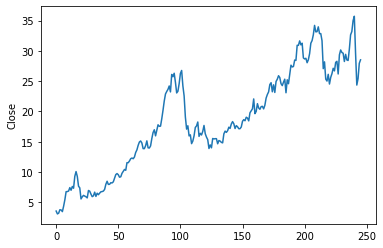

In [25]:
sns.lineplot(
    y = port.portfolio['PPL']['Close'], 
    x = range(len(port.portfolio['PPL']['Close']))
            )

In [ ]:
from dateutil.relativedelta import relativedelta


In [60]:
data_path = 'data/'
interval = '1d'
prefix = interval + '/'
date_format = '%Y-%m-%d'

In [32]:
ddf = pd.read_csv(data_path + prefix + 'AAPL' + '.csv')
mdf = pd.read_csv(data_path + 'monthly/' + 'AAPL' + '.csv')

In [50]:
dddf = ddf.set_index('Date')[252:]

In [73]:
data_start = '2000-01-01'
data_end = '2020-06-01'

data_months = list(pd.date_range(data_start, data_end, freq='MS').strftime(date_format))

In [79]:
start = '2001-01-01'

end = datetime.strptime(start, date_format) + relativedelta(months=1) - relativedelta(days=1)
end = datetime.strftime(end, date_format)

In [81]:
p = dddf[start:end].reset_index()

In [83]:
p.iloc[0]['Open'], max(p['High']), min(p['Low']), p.iloc[-1]['Close'], sum(p['Volume'])

(0.92, 1.39, 0.89, 1.34, 3427365200)

In [46]:
mdf[0:1]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2001-01-01,0.92,1.39,0.89,1.34,3.427365e+09,0.0,0.0


In [89]:
def build_1mo(ticker, data_path='data/'):
    if '.csv' in ticker:
        ticker_df = pd.read_csv(data_path + '1d/' + ticker)
    else:
        ticker_df = pd.read_csv(data_path + '1d/' + ticker + '.csv')
    date_format = '%Y-%m-%d'
    
    # These are hardcoded and should be more changed if more flexibility is desired
    data_start = '2000-01-01'
    data_end = '2020-05-01'
    
    month_list = list(pd.date_range(data_start, data_end, freq='MS').strftime(date_format))
    
    # Not currently coded for Dividends or Stock Splits
    months_dict = {
        'Date' : [], 
        'Open' : [], 
        'High' : [], 
        'Low' : [], 
        'Close' : [], 
        'Volume' : []
    }
    
    for start in month_list:
        end = datetime.strptime(start, date_format) + relativedelta(months=1) - relativedelta(days=1)
        end = datetime.strftime(end, date_format)
        
        month_df = ticker_df.set_index('Date')[start:end].reset_index()
        
        if len(month_df) > 0:
            months_dict['Date'].append(start)
            months_dict['Open'].append(month_df.iloc[0]['Open'])
            months_dict['High'].append(max(month_df['High']))
            months_dict['Low'].append(min(month_df['Low']))
            months_dict['Close'].append(month_df.iloc[-1]['Close'])
            months_dict['Volume'].append(sum(month_df['Volume']))
    
    months_df = pd.DataFrame.from_dict(months_dict)
    return months_df

In [94]:
list(range(10))[-1:]

[9]

In [112]:
# 4, [1, 2, 4]
# 1, 2, 1
# 1, 1, 2
# 1, 0, 3
# 0, 2, 2
# 0, 1, 3
# 0, 0, 4

In [104]:
# def balls_in_bins_helper(balls, bin_sizes):
    


def balls_in_bins(balls, bin_sizes):
    diff = min(balls, bin_sizes[0])
    lists = []
    for i in range(diff + 1):
        if len(bin_sizes) == 1:
            
        new_balls = balls-i
        new_bins = bin_sizes[1:]
        sum_new_bins = sum(new_bins)
        
        print(i, end='')
        
        if new_balls <= sum_new_bins:
            balls_in_bins(new_balls, bin_sizes[1:])
        print()

IndentationError: expected an indented block (<ipython-input-104-0fd9ed7f8ba2>, line 11)

In [101]:
def helper(bins, balls):
    rows = []
    for i in range(1, balls-1):
        ring_buffer = [0] * len(bins)
        
        remainder = balls
        j = 0
        while remainder > 0:
            if remainder - i <= 0:
                remainder = 0
                ring_buffer[j % len(bins)] += 1 - remainder
            else:
                remainder = -1
                ring_buffer[j % len(bins)] += i
                
            j += 1
            
        rows.append(ring_buffer)
        
    return rows

In [ ]:
def ibib(balls, bins):
    

In [103]:
helper([16, 1], 3)

[[1, 0]]

In [100]:
balls_in_bins(3, [15, 15])

00

IndexError: list index out of range

In [ ]:
def balls_in_bins(balls, bin_sizes):
    possibles_bins = []
    open_spots = sum(bin_sizes)
    
    for i in range(len(bin_sizes)):
        max_balls = bin_sizes[i]
        if max_balls > balls:
            